# A service for recommending movies and music


This service will solve the problem of selecting content (movies and music) for users. The recommendation system analyzes the behavior of users with similar preferences and gives a recommendation. This prototype implements the function of recommending a movie and music, as well as viewing the history of recommendations.

> Many services build recommendations based on only one type of content, whereas using several at once will improve recommendations and make them more relevant for the user. In addition, if a person does not particularly consume one type of content (does not watch movies or does not listen to music), this approach will allow to make a recommendation for the other one.



### Job Stories

1. When I have a free evening from work, I want to watch a movie that I will definitely like, so that I don't regret the time spent on it.
2. When I want to find new music for myself, I want the tracks to be recommended to me so as not to waste time searching among many options available on the internet.

### Conceptual model

| Objects | Attributes | Actions |
|:--------:|:--------:|:--------:|
|  Movie   |  -Name<br>-Age limit<br>-Description<br>-Link to the movie<br>-Poster | -Ask the system to recommend the movie<br>-View the history of recommended movies |
| Music track | -Title<br>-Artist<br>-Genre<br>-Album<br>-Link to the track<br>-Album cover | -Ask the system to recommend a track<br>-View the history of recommended tracks |

### С4 model

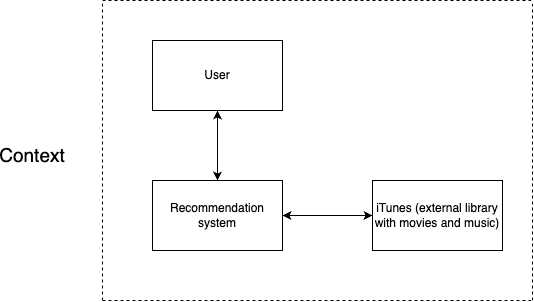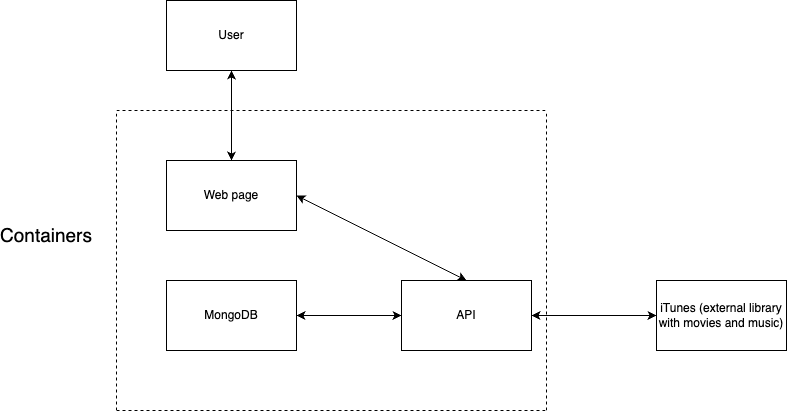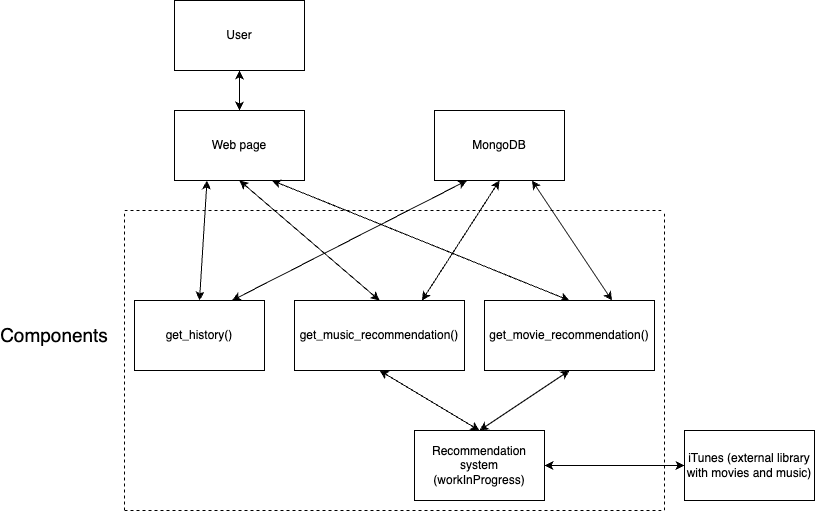

### Code

In [4]:
import requests
from jinja2 import Template
from IPython.display import display, HTML
from flask import Flask
from flask import render_template
from random import randint
import json

Use your own token for download NGROK

In [1]:
!wget -c https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!./ngrok authtoken # insert your token here

In [2]:
!pip install -U flask-restful 
!pip install -U flask-ngrok
!pip install dnspython
!pip install pip install mongoengine

In [5]:
from flask_ngrok import run_with_ngrok
from mongoengine import *

In [6]:
tmpl_model = '''
<!DOCTYPE html>
<html>
<body>
<img src={{ image }} /> <br/>

<h1 style=\"font-size: 40;\"> {{ title }} </h1>
<h2 style=\"font-size: 20;\">
    {% if movie_id %} Rating: {{ rating }}
    {% else %} Artist: {{ artist }}
    {% endif %}
</h2>

{% if music_id %}
<h3 style=\"font-size: 20;\">
Genre: {{ genre }} </br>
Album: {{ album }} </h3>
{% endif %}

<p> {{ description }} </p>

{% if movie_id %}
<a href={{ url }} style=\"font-size: 10;\">Watch this movie</a>
{% else %}
<a href={{ url }} style=\"font-size: 10;\">Listen this song</a>
{% endif %}

</body>
</html>
'''

In [7]:
tmpl_model_history = '''
<!DOCTYPE html>
<html>
<body>

<div style="display:block; width:100%;">
  <div style="width:50%; float: left; display: inline-block;">
    <td>
        <h1 style=\"font-size: 40;\"> Music </h1>
        {% for item in music_hist %}
        <li>{{ item['title'] }}  <a href={{ item['url'] }}">URL</a></li>
        {% endfor %}
    </td>
  </div>
  <div style="width:50%; float: left; display: inline-block;">
    <td>
        <h1 style=\"font-size: 40;\"> Movies </h1>
        {% for item in movie_hist %}
        <li>{{ item['title'] }}  <a href={{ item['url'] }}">URL</a></li>
        {% endfor %}
    </td>
  </div>
</div>

</body>
</html>
'''

In [3]:
app = Flask(__name__, template_folder='')
run_with_ngrok(app)

mydb = 'cringe_compiler_db'
cluster_url = # insert your cluster URL
db_username = # insert your username
db_password = # insert your password

class Movie(DynamicDocument):
    title = StringField(required=True)
    rating = StringField()
    description = StringField()
    url = URLField()
    image = URLField()
    movie_id = IntField()

class Music(DynamicDocument):
    title = StringField(required=True)
    artist = StringField()
    genre = StringField()
    album = StringField()
    url = URLField()
    image = URLField()
    music_id = IntField()

def recommend(ent_type):
    """
    This function is a stub function and returns (somewhat) randomised answer
    """
    if ent_type == 'movie':
        r = requests.get('https://itunes.apple.com/search?entity=movie&limit=25&term=love')
        num = randint(1, 25)
        return r.json()['results'][num]
    elif ent_type == 'musicTrack':
        r = requests.get('https://itunes.apple.com/search?entity=musicTrack&limit=25&term=eminem')
        num = randint(1, 25)
        return r.json()['results'][num]
    else:
        return 'recommendation_error'

@app.route("/")
def home():
    return "<h3 style=\"font-size: 40;\">You are visiting main page of my API.</h3> <br> <h2 style=\"font-size: 40;\">This is a prototype of a service for recommending music and movies. (by Timofei Iatskov) </h2>"

@app.route('/recommend/movie', methods=['GET'])
def get_movie_recommendation():
    """
    Method that recommends a movie
    """
    movie = recommend('movie')

    con = connect(host=cluster_url,
                 username=db_username,
                 password=db_password,
                 db=mydb)

    movie_doc = Movie(title=movie['trackName'],
            rating = movie['contentAdvisoryRating'],
            description = movie['longDescription'],
            url=movie['trackViewUrl'],
            image=movie['artworkUrl100'],
            movie_id = movie['trackId']).save()
    movie_json = json.loads(movie_doc.to_json())

    disconnect()

    tmodel = Template(tmpl_model)
    return tmodel.render(movie_json)


@app.route('/recommend/music', methods=['GET'])
def get_music_recommendation():
    """
    Method that recommends a music track 
    """
    music = recommend('musicTrack')

    con = connect(host=cluster_url,
             username=db_username,
             password=db_password,
             db=mydb)

    music_doc = Music(title=music['trackName'],
            artist=music['artistName'],
            genre = music['primaryGenreName'],
            album = music['collectionName'],
            url=music['trackViewUrl'],
            image=music['artworkUrl100'],
            music_id = music['trackId']).save()
    music_json = json.loads(music_doc.to_json())

    disconnect()

    tmodel = Template(tmpl_model)
    return tmodel.render(music_json)

@app.route('/history', methods=['GET'])
def get_history():
    """
    Method for displaying the history of recommendations for all types of content
    """
    con = connect(host=cluster_url,
         username=db_username,
         password=db_password,
         db=mydb)

    music_data = Music.objects.to_json()
    music_dicts = json.loads(music_data)

    movie_data = Movie.objects.to_json()
    movie_dicts = json.loads(movie_data)

    disconnect()

    tmodel = Template(tmpl_model_history)
    return tmodel.render(music_hist = music_dicts[::-1], movie_hist = movie_dicts[::-1])



app.run()

### Example of using this prototype

After calling the method for recommending music (adding */recommend/music* to the url), the browser displays the following page, which shows basic information about the recommended music track (Title, artist, link to Itunes, etc.):

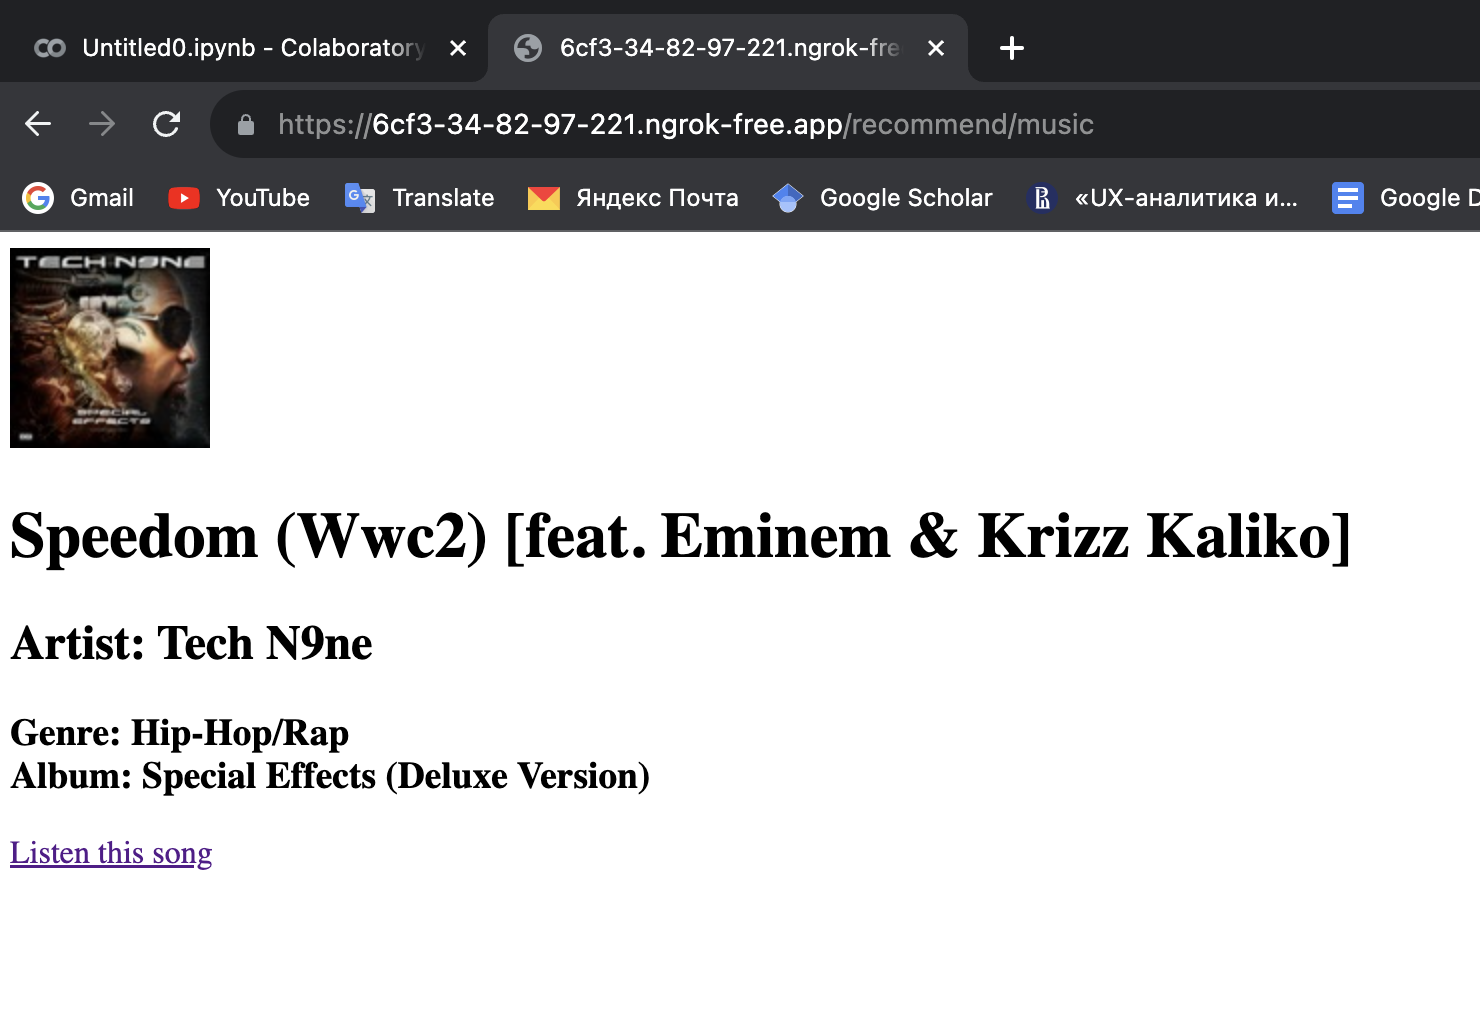

After calling the method to show the history of recommended content (adding */history* to the url), the browser displays a page with the latest recommended tracks and movies - the information includes the title and a link to listen/watch:

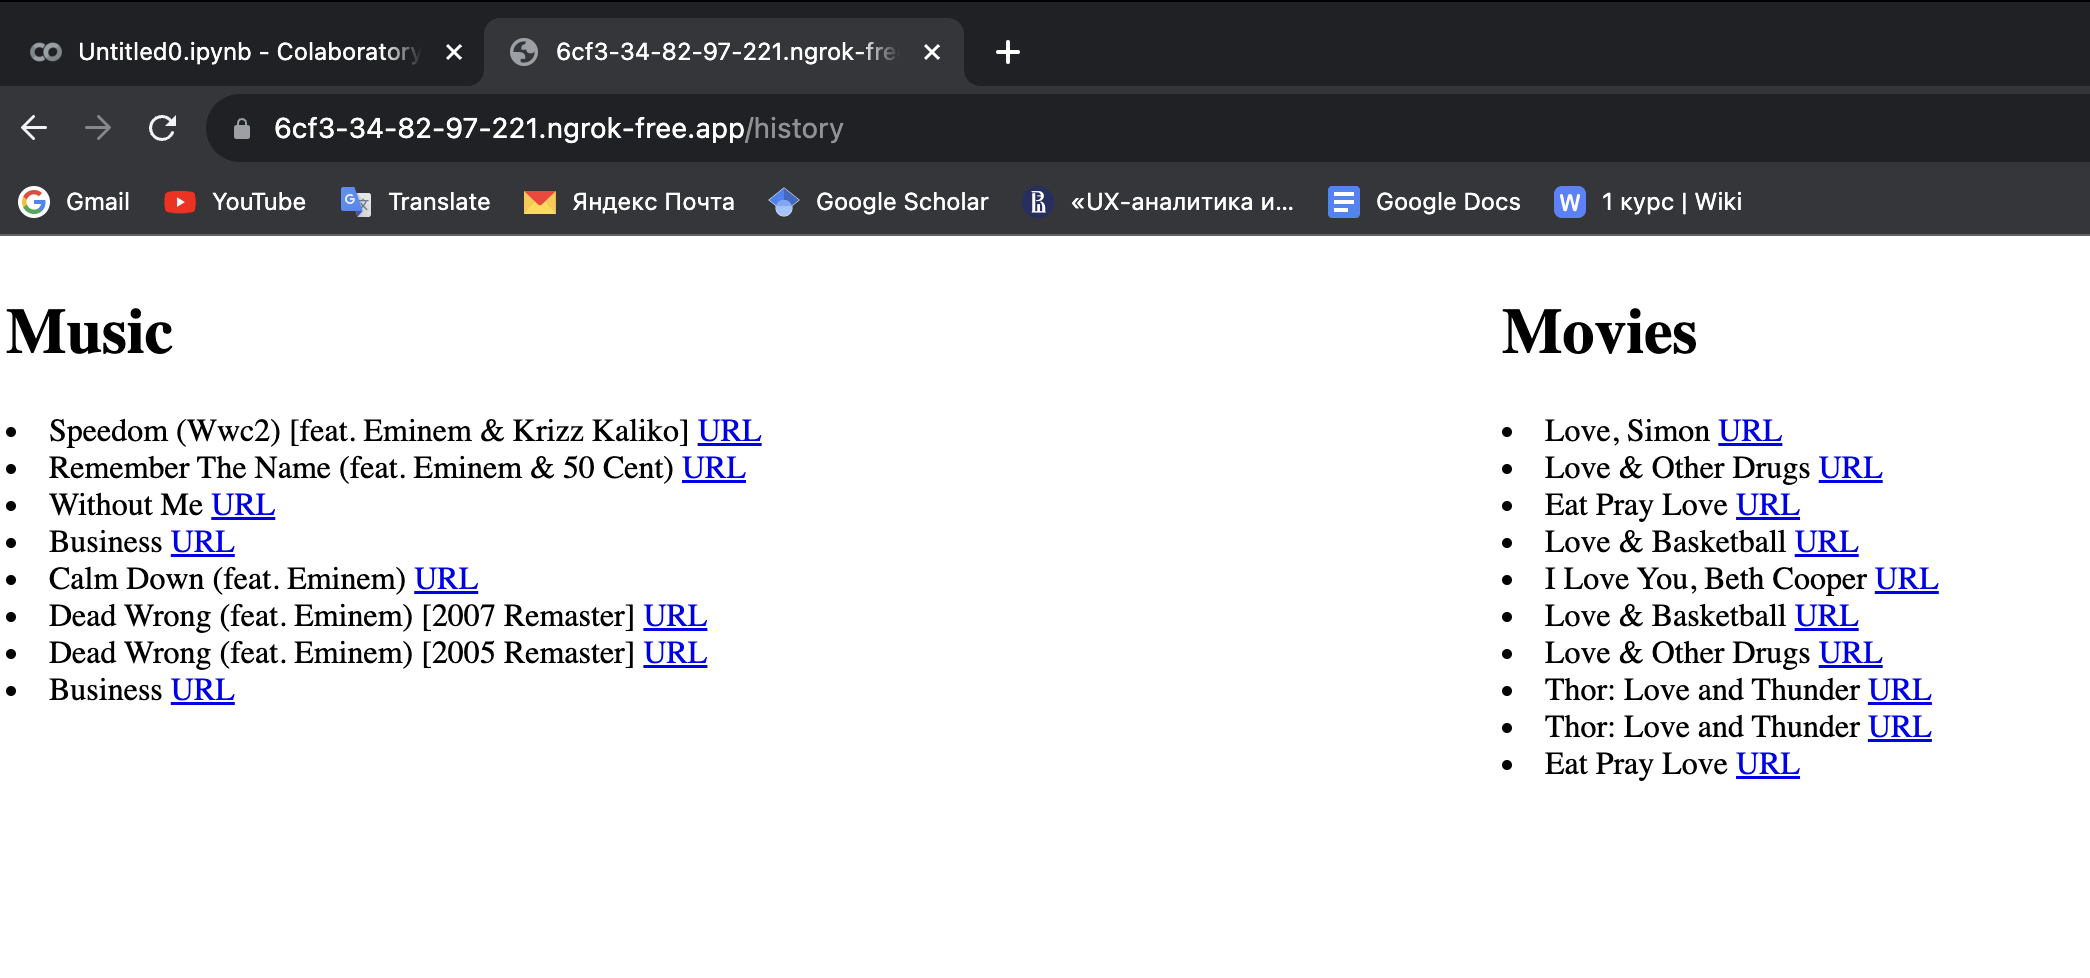